In [1]:
# importing all the required modules
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Dropout

In [2]:
# Loading the Data sets into a Data frame using pandas library
df1 = pd.read_csv("Downloads/train.csv")
df2 = pd.read_csv("Downloads/test.csv")

# Deleting null values in data
df1 = df1.dropna()
df2 = df2.dropna()

In [3]:
df1.head()

,input,output
0,"Bitcoin is for $7,094 this morning, which Coin...","Bitcoin goes for $7,094 this morning, accordin..."
1,The effect of widespread dud targets two face ...,"1. The effect of ""widespread dud"" targets two ..."
2,tax on sales of stores for non residents are s...,Capital Gains tax on the sale of properties fo...
3,Much many brands and sellers still in the market.,Many brands and sellers still in the market.
4,this is is the latest Maintenance release of S...,This is is the latest maintenance release of S...


In [4]:
df2.head()

,input,output
0,Organizational mission of Kiss The Ground is i...,The organizational mission of Kiss the Ground ...
1,Tap The Thumbnail Bellow to See Related Galler...,Tap The Thumbnail Bellow to See Related Galler...
2,when I relax that’s when I shake or jolt to me...,"if I relax that’s when I shake or jolt, like t..."
3,Our neighbor Jay-dub (nickname courtesy of me ...,Our neighbor Jay-dub (nickname courtesy me sin...
4,Kummrow Automotive is now a Official Distribut...,Kummrow Automotive is now an official Dinan Di...


In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   25000 non-null  object
 1   output  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [6]:
df1.shape, df2.shape

((71616, 2), (25000, 2))

In [7]:
# Assuming train_data and test_data are your datasets with input sentences and corrected sentences
# Taking subset of training data and test data for avoiding memory issues
train_data = df1[:10000]
test_data = df2[:2000]

In [8]:
# Create Tokenizer() object 
tokenizer = Tokenizer()

# assign an unique index for each word
# map of word with unique index i.., {word: unique_index}
tokenizer.fit_on_texts(train_data['input'])

# adding prefered words for decoding logic  
tokenizer.word_index['<start>'] = len(tokenizer.word_index) + 1
tokenizer.word_index['<end>'] = len(tokenizer.word_index) + 2

# convert sentences to numbered sequences
# After tokeniztion list of words --> words to list of word indexes
train_input_sequences = tokenizer.texts_to_sequences(train_data['input'])
test_input_sequences = tokenizer.texts_to_sequences(test_data['input'])

In [9]:
print(train_input_sequences[0])
print(test_input_sequences[0])

[2253, 8, 7, 78, 2254, 17, 2255, 37, 2256, 426]
[1990, 3, 1, 6496, 8, 2739, 375, 2321, 5, 1, 3, 39, 1403, 1882]


In [10]:
# output sentences -> tokenization -> list of words -> list of word indexes/numbers
tokenizer.fit_on_texts(train_data['output'])
train_target_sequences = tokenizer.texts_to_sequences(train_data['output'])
test_target_sequences = tokenizer.texts_to_sequences(test_data['output'])

In [11]:
print(train_target_sequences[0])
print(test_target_sequences[0])

[2464, 2356, 7, 82, 2465, 17, 2088, 633, 3, 2466]
[1, 1894, 4, 1, 2446, 8, 3, 2806, 459, 2510, 6, 1, 4, 35]


In [12]:
# Load pre-trained word embeddings
#The file glove.6B.50d.txt contains pre-trained word embeddings generated using the GloVe 
# (Global Vectors for Word Representation) algorithm. Here's what each part of the filename means:
#glove: This indicates that the embeddings were generated using the GloVe algorithm.
#6B: The GloVe algorithm was trained on a corpus of 6 billion tokens.
#50d: The embeddings are 50-dimensional vectors.
embeddings_index = {}
with open('Downloads/glove.6B.50d.txt', encoding='utf-8') as f:
    
#     logic for loading pre-trained word embeddings(Glove) from file to a dictionary
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# specify  the dimentionality of the word embeddings
embedding_dim = 50

In [13]:
# retrieve word_index from tokenizer object and assign to some variable
# it is a dictionary looks like {word: unique_number, ......}
word_index = tokenizer.word_index
num_words = len(word_index) + 1

# logic for creating embedding matrix --> {word_index: corresponding_embeddingVector, ....}
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [14]:
# Pad sequences dynamically - to ensure all are having equal length
max_len = 50
print(max_len)
train_input_sequences = pad_sequences(train_input_sequences, maxlen=max_len, padding='post')
test_input_sequences = pad_sequences(test_input_sequences, maxlen=max_len, padding='post')
train_target_sequences = pad_sequences(train_target_sequences, maxlen=max_len, padding='post')
test_target_sequences = pad_sequences(test_target_sequences, maxlen=max_len, padding='post')

50


In [15]:
print(train_input_sequences[0])

[2253    8    7   78 2254   17 2255   37 2256  426    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [16]:
# Define a Sequential model 
model =  tf.keras.Sequential()
model.add(Embedding(input_dim=num_words, output_dim=embedding_dim))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Dense(units=num_words, activation='softmax'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [17]:
# Train the model with reduced batch size
model.fit(train_input_sequences, train_target_sequences,
          epochs=15, batch_size=32,
          validation_data=(test_input_sequences, test_target_sequences))

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.4628 - loss: 5.5593 - val_accuracy: 0.6699 - val_loss: 2.4679
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 590ms/step - accuracy: 0.5956 - loss: 3.1335 - val_accuracy: 0.6840 - val_loss: 2.3325
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 592ms/step - accuracy: 0.6176 - loss: 2.8795 - val_accuracy: 0.6902 - val_loss: 2.3047
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 572ms/step - accuracy: 0.6106 - loss: 2.8084 - val_accuracy: 0.7004 - val_loss: 2.2941
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 545ms/step - accuracy: 0.6372 - loss: 2.4721 - val_accuracy: 0.7106 - val_loss: 2.3043
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 598ms/step - accuracy: 0.6530 - loss: 2.1806 - val_accuracy: 0.7165 - val_loss: 2.3237
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 670ms/step - accuracy: 0.6992 - loss: 1.7524 - val_accuracy: 0.7220 - val_loss: 2.3707
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 817ms/step - accuracy: 0.7388 - loss: 1.4603 - val_accu

In [21]:
# Evaluate the model
loss, accuracy = model.evaluate(test_input_sequences, test_target_sequences)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.7205 - loss: 2.8361
Test Loss: 2.8317182064056396
Test Accuracy: 0.7238000631332397


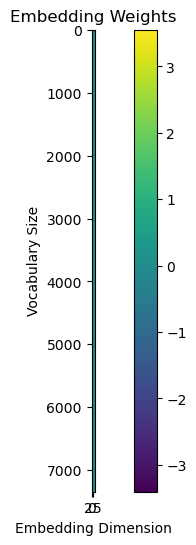

In [22]:
# Accessing the embedding weights
#This code snippet retrieves the embedding weights from the first layer of the model
#(which is the embedding layer) and visualizes them using matplotlib. Each row in the 
#visualization represents the embedding vector for a specific word in the vocabulary.
embedding_weights = model.layers[0].get_weights()[0]

# Visualizing the embedding weights
plt.figure(figsize=(10, 6))
plt.imshow(embedding_weights, cmap='viridis')
plt.colorbar()
plt.title('Embedding Weights')
plt.xlabel('Embedding Dimension')
plt.ylabel('Vocabulary Size')
plt.show()

In [20]:
# For new sentences pr
# Decode the Predicted sequences to Sentences
# Function to decode sequences into sentences
tokenizer.word_index['<end>'] = len(tokenizer.word_index) + 1
def decode_sequence(input_sequence):
    decoded_sentence = ''
    for token in input_sequence:
        sampled_token_index = np.argmax(token)
        if sampled_token_index == 0:  # <pad> token
            continue
        if sampled_token_index == tokenizer.word_index['<end>']:  # <end> token
            break
        decoded_sentence += tokenizer.index_word[sampled_token_index] + ' '
    return decoded_sentence.strip()
 
# Decode test sequences
decoded_predictions = []
for input_seq in train_input_sequences[4:8]:
    input_seq = np.expand_dims(input_seq, axis=0)
    decoded_seq = decode_sequence(model.predict(input_seq)[0])
    decoded_predictions.append(decoded_seq)
    
 # Print decoded sentences
for i in range(len(train_data[4:8])):
    print("Input:", train_data['input'].iloc[4+i])
    print("Target:", train_data['output'].iloc[4+i])
    print("Predicted:", decoded_predictions[i])
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Input: this is is the latest Maintenance release of Samba 3.6
Target: This is is the latest maintenance release of Samba 3.6.
Predicted: this is is the latest maintenance release of samba 3 6

Input: Fairy Or Not, I'm the Godmother: no just look, but my outfit for taking the part as godmother.
Target: Fairy Or Not, I'm the Godmother: Not just a look, but my outfit for taking on the role as godmother.
Predicted: fairy or not i'm the godmother no just a look my my outfit for taking availability the role as

Input: Watcch as this Dodge Challenger Hellcat gets smoked by a Tesla Model S - with the drag strip.
Target: Watch as this Dodge Challenger Hellcat gets smoked by a Tesla Model S at the drag strip.
Predicted: watch as this dodge challenger hellcat gets smoked by a tesla model s with the drag strip

Input: Momover, these devices have b